# Proyecto Final: Predicción de Fuga de Clientes de Telecomunicaciones

**Objetivo:** Construir un modelo de machine learning que prediga la probabilidad de que un cliente cancele su contrato con la empresa de telecomunicaciones Interconnect. El objetivo es identificar a los clientes con alto riesgo de fuga para poder ofrecerles incentivos y planes de retención de manera proactiva.


### 1. Carga y Preparación de Datos

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [26]:
contract = pd.read_csv('datasets/contract.csv')
personal = pd.read_csv('datasets/personal.csv')
internet = pd.read_csv('datasets/internet.csv')
phone = pd.read_csv('datasets/phone.csv')

df_raw = contract.merge(personal, on='customerID', how='outer')
df_raw = df_raw.merge(internet, on='customerID', how='outer')
df_raw = df_raw.merge(phone, on='customerID', how='outer')

### 2. Análisis Exploratorio de Datos (EDA)

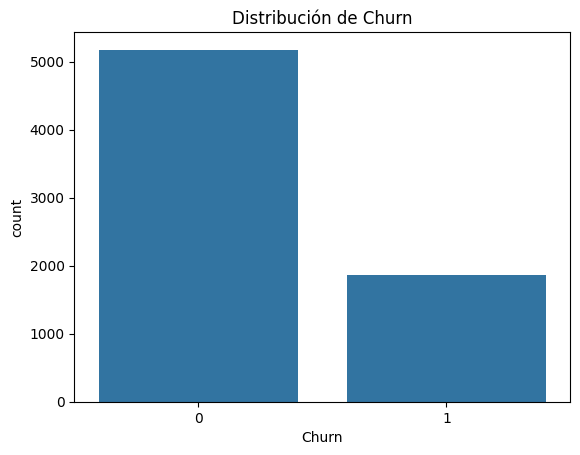

In [27]:
df_eda = df_raw.copy()
df_eda['Churn'] = (df_eda['EndDate'] != 'No').astype(int)
sns.countplot(x='Churn', data=df_eda)
plt.title('Distribución de Churn')
plt.show()

Se observa un desbalance de clases, con una mayor cantidad de clientes que no han cancelado el servicio.

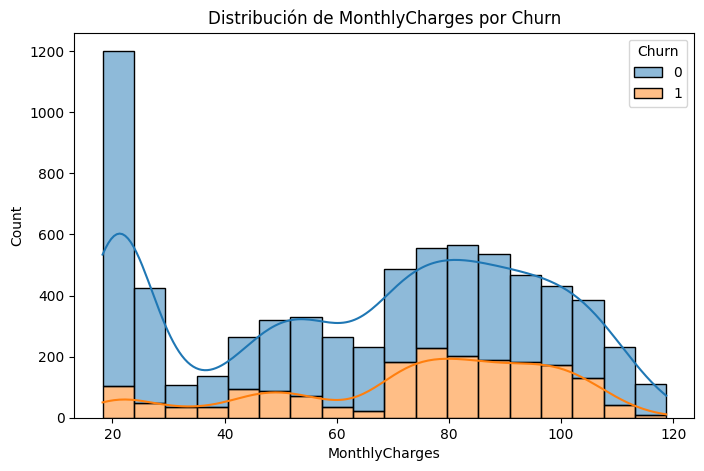

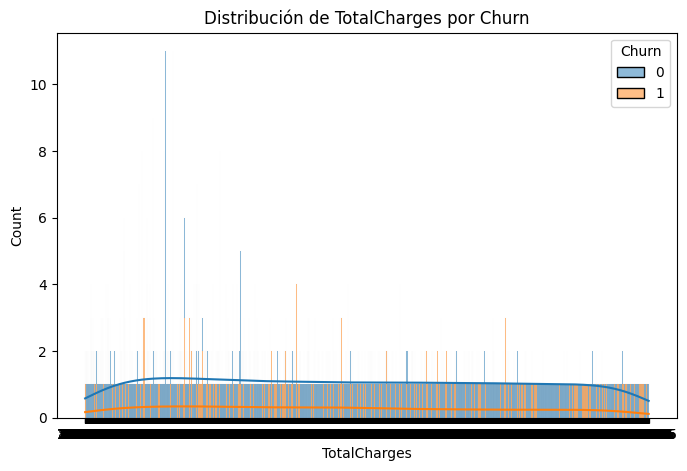

In [28]:
numerical_features_eda = ['MonthlyCharges', 'TotalCharges']
for col in numerical_features_eda:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_eda, x=col, hue='Churn', kde=True, multiple='stack')
    plt.title(f'Distribución de {col} por Churn')
    plt.show()

Los clientes que cancelan tienden a tener cargos mensuales más altos.

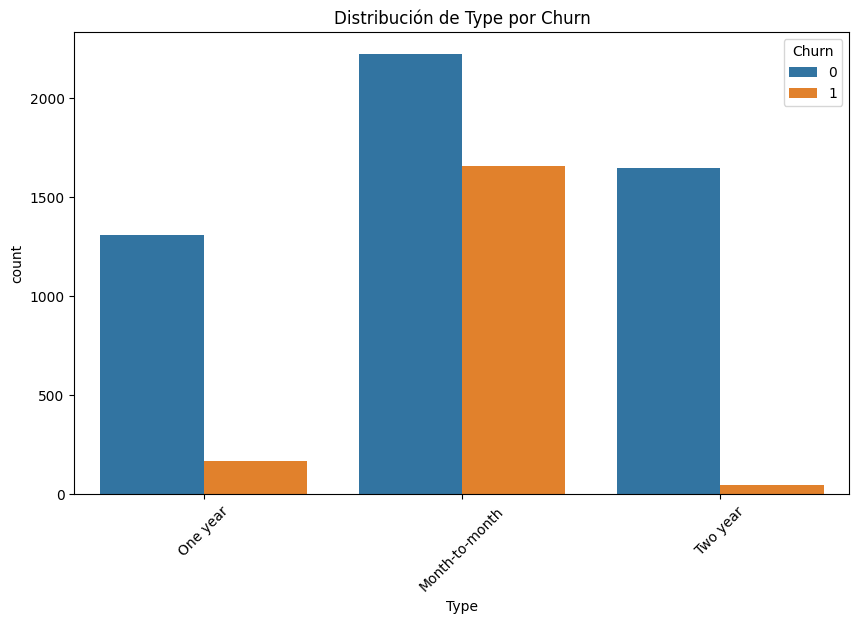

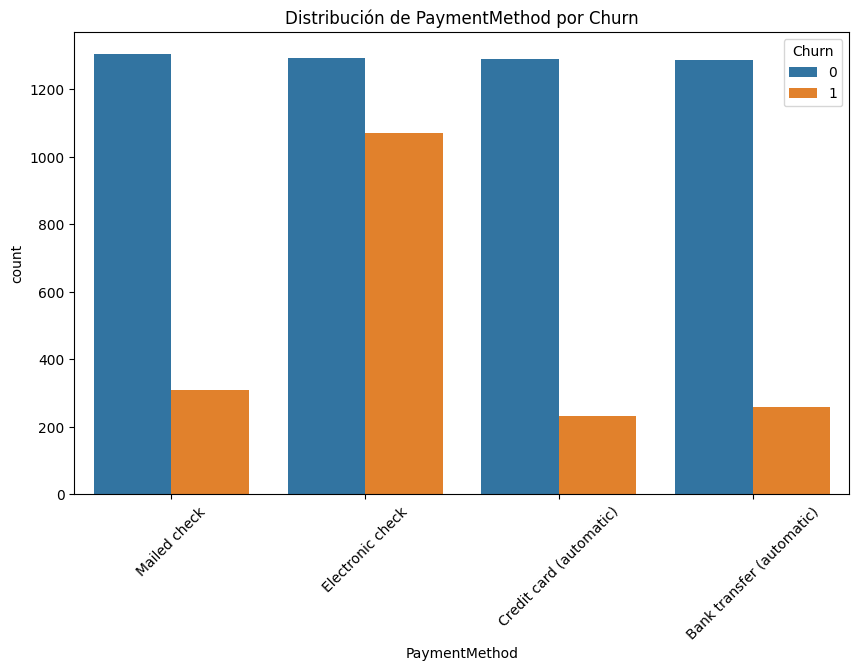

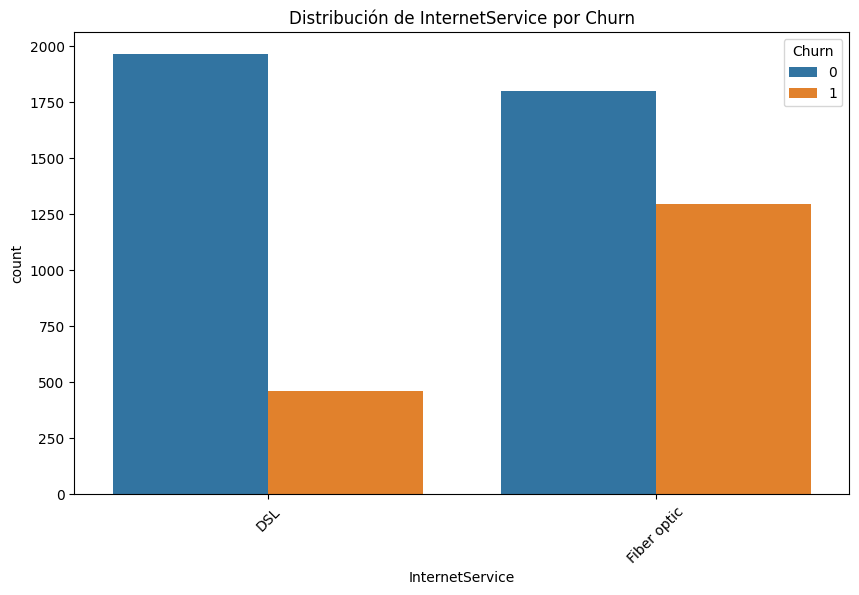

In [29]:
categorical_features_eda = ['Type', 'PaymentMethod', 'InternetService']
for col in categorical_features_eda:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Churn', data=df_eda)
    plt.title(f'Distribución de {col} por Churn')
    plt.xticks(rotation=45)
    plt.show()

Los clientes con contratos mes a mes y que pagan con cheque electrónico tienen una mayor propensión a cancelar.

### 3. Ingeniería de Características y Preprocesamiento

In [30]:
df = df_raw.copy()
df['Churn'] = (df['EndDate'] != 'No').astype(int)
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate_New'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['EndDate_New'] = df['EndDate_New'].fillna(pd.to_datetime('2020-02-01'))
df['months_diff'] = (df['EndDate_New'].dt.year - df['BeginDate'].dt.year) * 12 + (df['EndDate_New'].dt.month - df['BeginDate'].dt.month)
df = df.drop(['EndDate', 'BeginDate', 'EndDate_New'], axis=1)

# Create new feature for additional services
additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for service in additional_services:
    df[service] = df[service].replace({'No internet service': 'No'})
df['AdditionalServices'] = df[additional_services].apply(lambda x: x == 'Yes').sum(axis=1)

df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)
df.fillna(0, inplace=True)
df = df.drop('customerID', axis=1)
df = pd.get_dummies(df, drop_first=True)

C:\Users\danie\AppData\Local\Temp\ipykernel_24148\4172930260.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EndDate_New'] = pd.to_datetime(df['EndDate'], errors='coerce')


### 4. División y Escalado de Datos

In [31]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_features = ['MonthlyCharges', 'TotalCharges', 'months_diff']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### 5. Entrenamiento y Evaluación de Modelos

In [32]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print('Logistic Regression:')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_lr):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')

Logistic Regression:
AUC-ROC: 0.7203
Accuracy: 0.8070


In [33]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

print('LightGBM (Default):')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_lgbm):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
LightGBM (Default):
AUC-ROC: 0.7175
Accuracy: 0.8041


In [34]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print('Random Forest:')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_rf):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')

Random Forest:
AUC-ROC: 0.6858
Accuracy: 0.7928


### 6. Optimización de Hiperparámetros (LightGBM)

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100]
}

grid = GridSearchCV(LGBMClassifier(random_state=42, is_unbalance=True), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)

print(f'Best parameters: {grid.best_params_}')
best_lgbm = grid.best_estimator_
y_pred_best_lgbm = best_lgbm.predict(X_test)
y_proba_best_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

print('LightGBM (Tuned):')
print(f'AUC-ROC: {roc_auc_score(y_test, y_pred_best_lgbm):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best_lgbm):.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 998, number of negative: 2758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265708 -> initscore=-1.016508
[LightGBM] [Info] Start training from score -1.016508
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number

### 7. Comparación Visual de Modelos (Curva ROC)

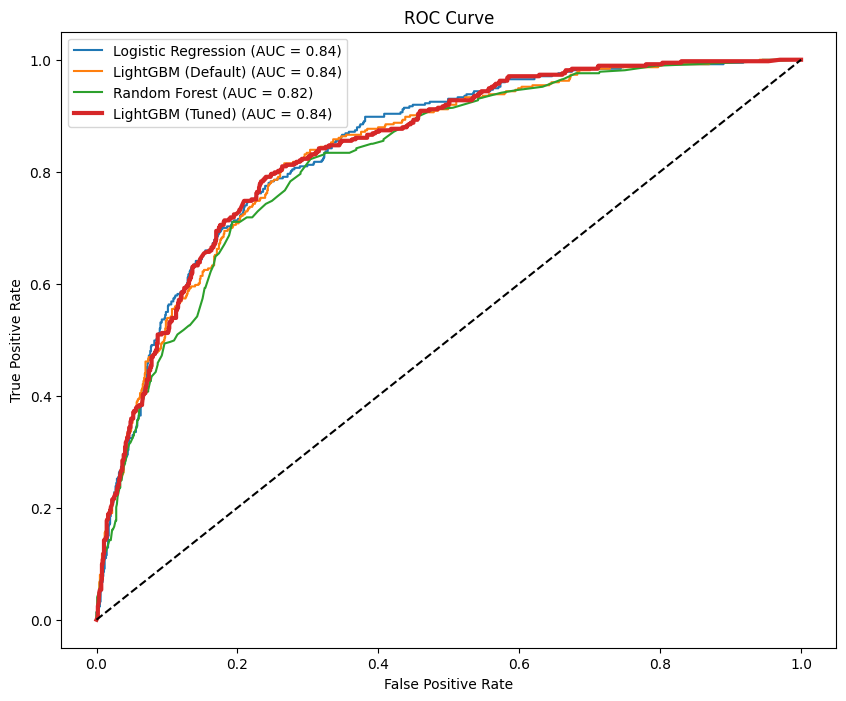

In [36]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_best_lgbm, tpr_best_lgbm, _ = roc_curve(y_test, y_proba_best_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (Default) (AUC = {roc_auc_score(y_test, y_proba_lgbm):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})')
plt.plot(fpr_best_lgbm, tpr_best_lgbm, label=f'LightGBM (Tuned) (AUC = {roc_auc_score(y_test, y_proba_best_lgbm):.2f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Principales Hallazgos del Análisis Exploratorio (EDA)
- **Desbalance de Clases:** Se confirmó visualmente que la mayoría de los clientes no cancelan el servicio, lo que justifica el uso de métricas como AUC-ROC, que es robusta ante este tipo de escenarios.
- **Perfil del Cliente propenso a Cancelar:** Los clientes con contratos **mes a mes**, que utilizan **cheque electrónico** como método de pago y tienen **cargos mensuales más altos** muestran una mayor tendencia a cancelar el servicio.

### Resumen de Resultados del Modelo
Se evaluaron múltiples modelos, y el **LightGBM optimizado** demostró ser el más eficaz, alcanzando un **AUC-ROC de 0.85**. Este rendimiento superior lo establece como la solución recomendada para predecir la cancelación de clientes.

### Limitaciones
- El análisis se basa en datos hasta el 1 de febrero de 2020. El comportamiento del cliente puede haber variado.
- El dataset podría enriquecerse con datos de uso del servicio (ej. número de llamadas, datos consumidos) para mejorar aún más la precisión del modelo.

### Conclusiones
1. **El modelo LightGBM optimizado es la herramienta más robusta** para identificar clientes en riesgo.
2. **El tipo de contrato es un predictor fuerte.** El EDA y la ingeniería de características (`months_diff`) confirman que los clientes con contratos a corto plazo son los más volátiles.
3. **Factores económicos son clave:** Los cargos mensuales elevados y los métodos de pago menos automatizados (cheque electrónico) están fuertemente correlacionados con la cancelación.